# Design 01 - BM3 WT Heme vs FDA Library

## Aim

- Test BM3 WT Heme vs FDA Library, including 'bad' compounds that interfere with measurement
    - edge cases will help process development
- Test each compound at 8 concentrations
    - mitigate well errors (e.g. dispensing error)
    - more accurate K<sub>d</sub> calculation


In [1]:
import os
import re
from string import ascii_uppercase, ascii_lowercase
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import echo

# compound library
df = pd.read_csv('layouts.csv',index_col=0)
df.head()

,Item Name,CatalogNumber,SMILES,Rack Number,Plate Location
0,Axitinib,S1005,CNC(=O)C1=CC=CC=C1SC1=CC2=C(C=C1)C(\C=C\C1=CC=...,L1300-01,a1
1,Afatinib (BIBW2992),S1011,CN(C)C\C=C\C(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)...,L1300-01,b1
2,Bortezomib (Velcade),S1013,CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=...,L1300-01,c1
3,Bosutinib (SKI-606),S1014,COC1=C(Cl)C=C(Cl)C(NC2=C(C=NC3=CC(OCCCN4CCN(C)...,L1300-01,d1
4,Dasatinib (BMS-354825),S1021,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(Cl)C=CC=C2C)=CC(...,L1300-01,e1


## Need to put these in `sxfst.utils`

should test them out first

In [2]:
def mapWell384(well, xoff=0, yoff=0):
    '''
    map pipetting from 96 to 384 well plate, 
    given a multi-channel pipette and an offset
    '''
    assert re.search('[a-zA-Z][0-9]+', well) is not None
    let, num = re.search('([a-zA-Z])([0-9]+)', well).groups()
    let = ascii_uppercase[ascii_uppercase.index(let.upper()) * 2 + yoff]
    num = int(((int(num)-1) * 2) + 1 + xoff)
    return f'{let}{num}'

class WellArr:
    '''
    Construct for plotting plates
    '''
    def __init__(self):
        self.x = np.zeros((16,24))
    def __getitem__(self, idx):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            return self.x[i,j]
    def __setitem__(self, idx, new):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            self.x[i,j] = new
    def __len__(self):
        return len(self.x.flatten())

## Dispensing Source Plates

In [3]:
racks = {i:df.loc[df['Rack Number'] == i,:] for i in df['Rack Number'].unique()}

# start at 0.1 bc there's already a [0] conc well for each run
conc_grad = np.linspace(0.1,1,5)**2 * 0.05*40

src_cpds = []

src_plates = []
dest_plates = []

for i in range(len(racks) // 4): # 4 src racks (96) per src plate (384)
    racks_ = list(racks.keys())[i*4:i*4+4] # list of rack names in groups of 4
    d = {} # source plate well allocation, echo.Cpd  objects
    src_ = echo.SrcPlate(ldv=True, 
                         name=f'src racks {i*4}..{i*4+4}')
    for rack, yoff, xoff in zip(racks_, 
                                [0,0,1,1], 
                                [0,1,0,1]):
        rack_df = racks[rack] # get compound layouts DataFrame chunk 
        for rackWell, catNum in zip(rack_df['Plate Location'], 
                                    rack_df['CatalogNumber']):
            cpd = echo.Cpd(name=catNum, vol=100) # assume excess
            srcWell = mapWell384(rackWell, xoff=xoff, yoff=yoff) 
            src_[srcWell].fill(cpd.sample(12))
            d[srcWell] = cpd
    src_plates.append(src_) # list of src plate objects
    src_cpds.append(d) # list of dicts for each source plate, not so different to src_plates
    


## Dispensing Destination Plates

In [4]:
src_

src racks 8..12 384

In [5]:
for i, src_ in zip(range(len(racks) // 4),
                   src_plates):           
    # generator - returns wells for max 5 dest plates
    destwells = (well for num in range(5) \
                 for well in echo.DestPlate(name=f'dest racks {i*4}..{i*4+4} {num}'))
    for srcwell in d:
        for destwell, vol in zip(destwells, conc_grad):
            src_[srcwell].xfer(destwell, vol)

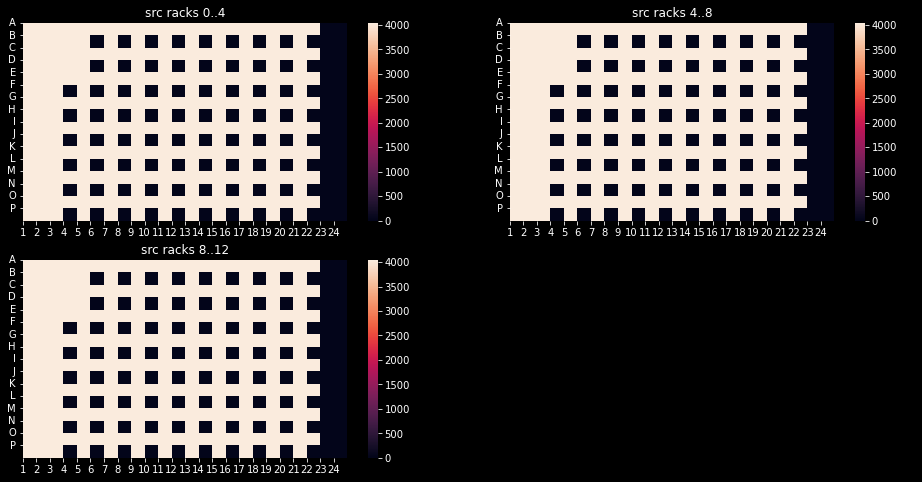

In [6]:
fig, ax = plt.subplots(2,2,figsize=(16,8))
for src_, ax_ in zip(src_plates, ax.flatten()):
    picklist = pd.DataFrame(src_.xfer_record).sort_values(\
                                    ['Destination Plate Name','SrcWell'])
    # echo doesn't allow 0 nl
    picklist = picklist.loc[picklist['Transfer Volume /nl'] != 0., :] 
            
    x = WellArr()
    for i, j in zip(picklist.SrcWell, 
                    picklist['Transfer Volume /nl']):
        x[i] += j

    sns.heatmap(x.x, annot=False, ax=ax_, linecolor='black')
    ax_.set_title(src_.name)
    ax_.set_xticks(range(24), range(1,25))
    ax_.set_yticks(range(16), list(ascii_uppercase)[:16], rotation=0)

ax[1,1].axis('off')
plt.show()

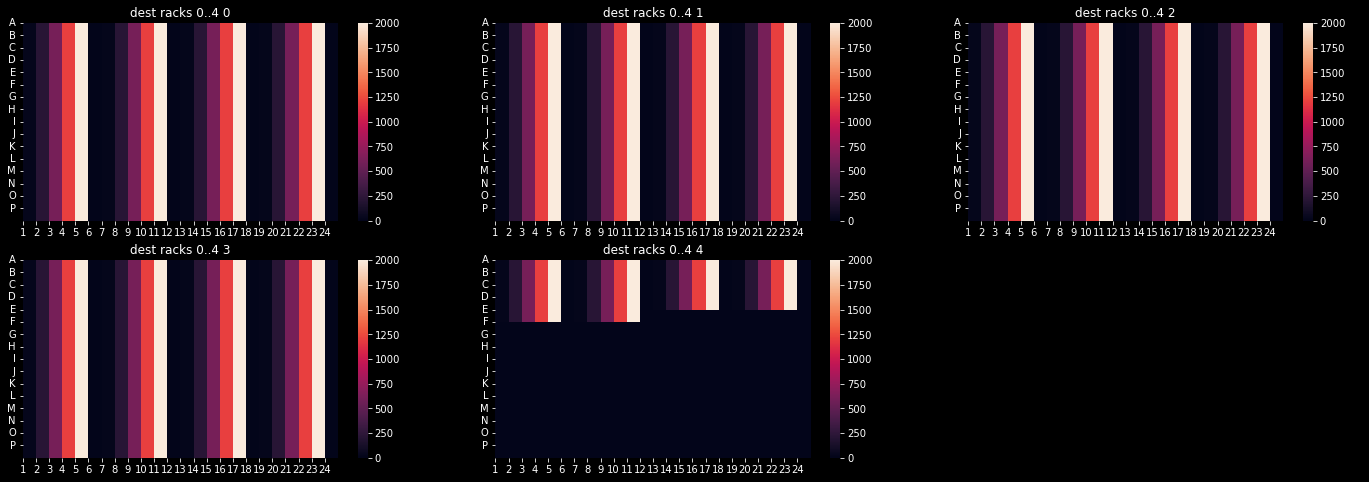

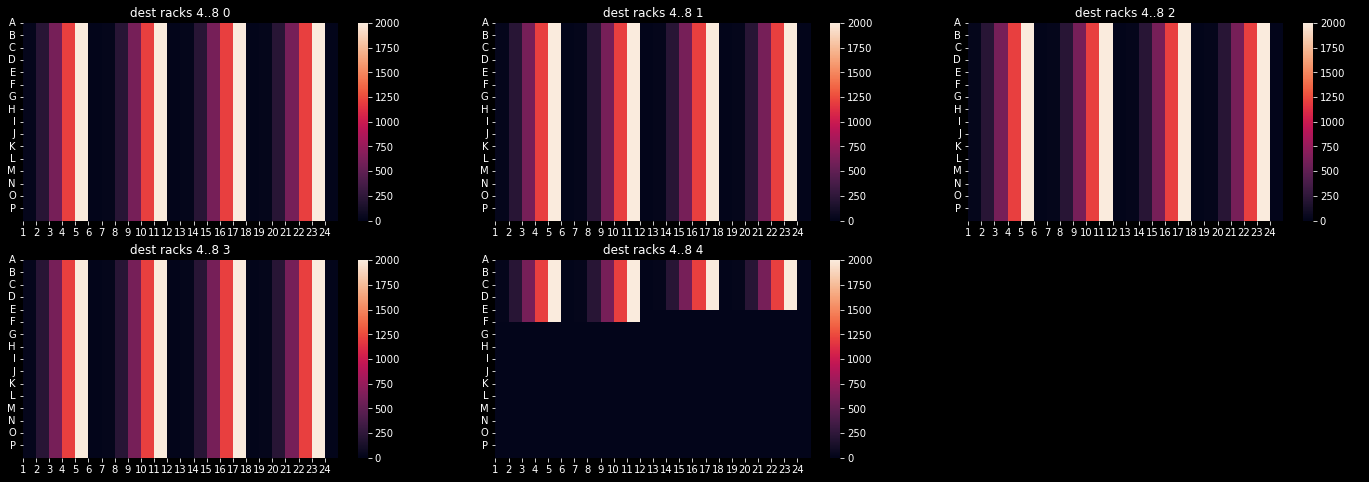

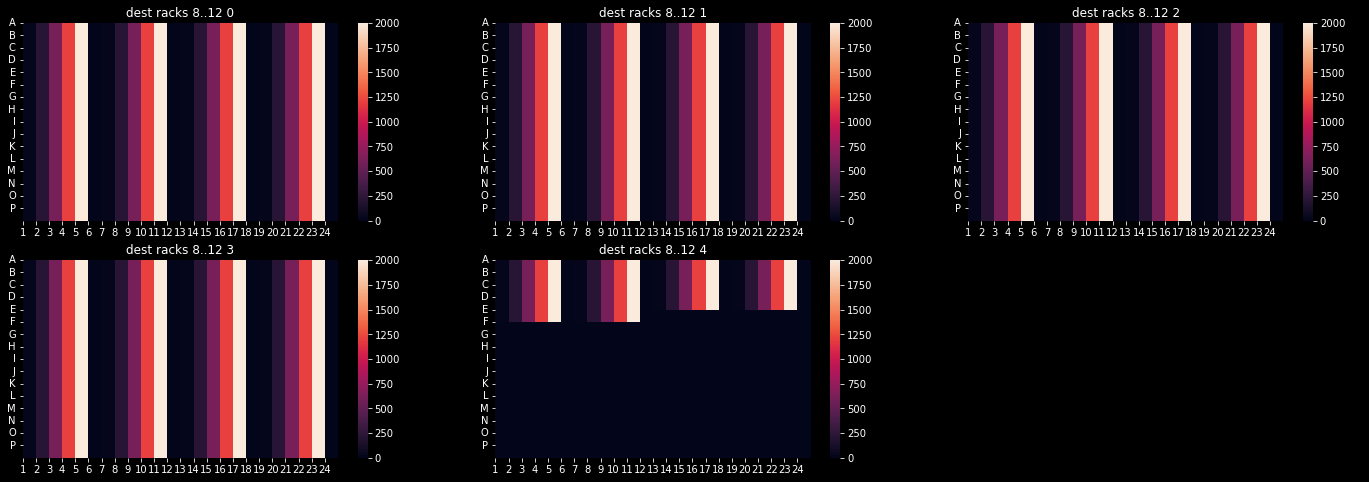

In [7]:
for src_ in src_plates:
    picklist = pd.DataFrame(src_.xfer_record).sort_values(['Destination Plate Name','SrcWell'])
    picklist = picklist.loc[picklist['Transfer Volume /nl'] != 0., :] # echo doesn't allow 0 nl
    fig, ax = plt.subplots(2,3,figsize=(24,8))
    for destPlate, ax_ in zip(picklist['Destination Plate Name'].unique(), ax.flatten()):
        picklist_ = picklist.loc[picklist['Destination Plate Name'] == destPlate,:]
            
        x = WellArr()
        for i, j in zip(picklist_.DestWell, 
                        picklist_['Transfer Volume /nl']):
            x[i] += j

        sns.heatmap(x.x, annot=False, ax=ax_)
        ax_.set_title(destPlate)
        ax_.set_xticks(range(24), range(1,25))
        ax_.set_yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
    ax[-1][-1].axis('off')
    plt.show()

## Assemble picklist

In [8]:
picklists_ = []

for src_ in src_plates:
    picklist_ = pd.DataFrame(src_.xfer_record).sort_values(\
                                ['Destination Plate Name','SrcWell'])
    # echo doesn't allow 0 nl
    picklist_ = picklist_.loc[picklist_['Transfer Volume /nl'] != 0., :] 
    picklists_.append(picklist_)

picklist = pd.concat(picklists_).reset_index(drop=True)
picklist['Cpd'] = [i[0] for i in picklist['Cpd']] # unpack list

odir = '../echo/picklist'
if not os.path.exists(odir):
    os.makedirs(odir)
picklist.to_csv(os.path.join(odir, '01-picklist.csv'))
picklist

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl
0,src racks 0..4,S1005,A1,dest racks 0..4 0,A1,20.0
1,src racks 0..4,S1005,A1,dest racks 0..4 0,A2,212.5
2,src racks 0..4,S1005,A1,dest racks 0..4 0,A3,605.0
3,src racks 0..4,S1005,A1,dest racks 0..4 0,A4,1202.5
4,src racks 0..4,S1005,A1,dest racks 0..4 0,A5,2000.0
...,...,...,...,...,...,...
4105,src racks 8..12,S4401,P21,dest racks 8..12 4,B19,20.0
4106,src racks 8..12,S4401,P21,dest racks 8..12 4,B20,212.5
4107,src racks 8..12,S4401,P21,dest racks 8..12 4,B21,605.0
4108,src racks 8..12,S4401,P21,dest racks 8..12 4,B22,1202.5


## Total compound volume used

Assuming an identical control

In [9]:
total_vols = []
for cpd in picklist['Cpd'].unique():
    ci = picklist.loc[picklist['Cpd'] == cpd, :]
    total_vols.append(sum(ci['Transfer Volume /nl']) * 2)
    
set(total_vols)

{8080.0}

## Inventory Check

In [10]:
import datetime

nThermoPlates = 154
nEchoPlates = 40

tDispense11 = datetime.timedelta(hours=1, minutes=4)
tDispensePlate = tDispense11 / 11

tRead11 = datetime.timedelta(hours=2)
tReadPlate = tRead11 / 11

volPerWell = 40
fluidPlate = 384 * volPerWell # ul

cpdsPerPlate = 384 // (nConcs:=5)

print(tDispensePlate)
print(tReadPlate)
print(fluidPlate)
print(cpdsPerPlate)

0:05:49.090909
0:10:54.545455
15360
76


In [11]:
volFluidScreen = fluidPlate/1000 * (980/96) 
volConcProtPerScreen = (volFluidScreen / 20) * 0.3
round(volConcProtPerScreen, 2) # about 3 tubes

2.35

In [12]:
sorted(picklist['Destination Plate Name'].unique())

['dest racks 0..4 0',
 'dest racks 0..4 1',
 'dest racks 0..4 2',
 'dest racks 0..4 3',
 'dest racks 0..4 4',
 'dest racks 4..8 0',
 'dest racks 4..8 1',
 'dest racks 4..8 2',
 'dest racks 4..8 3',
 'dest racks 4..8 4',
 'dest racks 8..12 0',
 'dest racks 8..12 1',
 'dest racks 8..12 2',
 'dest racks 8..12 3',
 'dest racks 8..12 4']